Некоторые ячейки не запущены в силу больших затрат на проведение эксперимента и редактирования кода после этого, результат работы в файле с названием arbitrated_k.ipynb в данном каталоге. Реализованные композиции Adaptive selection и Adaptive combination находятся в файле realize_compositions.ipynb

# Подготовка данных

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as sc
from sklearn import preprocessing
from utils import qualityMACAPE, qualityRMSE
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook
from sklearn.utils.extmath import softmax
import pickle

%matplotlib inline
np.random.seed(68)

In [2]:
prod_feat = ['STORE_LOCATION_LVL_NM2', 'ST_LOC_DIVISION_NM', 'ST_LOC_MNGMT_CLSTR', 'PRODUCT_DESC']

In [3]:
ts = pd.read_csv('./EGG_train.csv', encoding="cp1251", sep=';', decimal=',', parse_dates=True, dayfirst=True)
# parse dates
ts['period_start_dt'] = [ datetime.strptime(date, '%d%b%Y').toordinal() for date in ts['period_start_dt'] ]
ts = ts.sort_values(by=['PRODUCT_ID', 'STORE_LOCATION_ID', 'period_start_dt'])
ts = ts.groupby(['PRODUCT_ID', 'STORE_LOCATION_ID']).agg(
    lambda x: list(x)[0] if type(list(x)[0]) is str else list(x) )

In [4]:
ts.iloc[:2]

period_start_dt  \
PRODUCT_ID STORE_LOCATION_ID                                                      
475861     833805             [737045, 737046, 737047, 737048, 737049, 73705...   
           833807             [737045, 737046, 737047, 737048, 737049, 73705...   

                                                                     demand_qty  \
PRODUCT_ID STORE_LOCATION_ID                                                      
475861     833805             [5, 15, 3, 3, 4, 2, 2, 4, 4, 7, 13, 13, 13, 11...   
           833807             [40, 50, 36, 34, 55, 38, 35, 49, 36, 60, 58, 5...   

                             STORE_LOCATION_LVL_NM2 STORE_LOCATION_LVL_NM7  \
PRODUCT_ID STORE_LOCATION_ID                                                 
475861     833805                  59 ПЕРМСКИЙ КРАЙ    22_1119160 ЛЫСЬВА Г   
           833807                  72 ТЮМЕНСКАЯ ОБЛ    22_1180983 ТЮМЕНЬ Г   

                             ST_LOC_DIVISION_NM ST_LOC_MNGMT_CLSTR  \
PRODUCT_ID STORE_LOCATION_ID                                         
475861     833805                            UR             D_UR17   
           833807                            UR             D_UR29   

                               PRODUCT_LVL_NM8             PRODUCT_LVL_NM13  \
PRODUCT_ID STORE_LOCATION_ID                                                  
475861     833805             FR0607000 - Яйцо  42_FR0607001 - Яйцо куриное   
           833807             FR0607000 - Яйцо  42_FR0607001 - Яйцо куриное   

                                                  PRODUCT_DESC  
PRODUCT_ID STORE_LOCATION_ID                                    
475861     833805             ТЕНДЕР Яйца кур.С0 стол.фас.10шт  
           833807             ТЕНДЕР Яйца кур.С0 стол.фас.10шт

In [5]:
base_algs = pd.read_csv('./EGG_BA_FCST.csv', encoding="cp1251", sep=';',
                        decimal=',', parse_dates=True, dayfirst=True)
# parse dates
base_algs['dt'] = [ datetime.strptime(date, '%d%b%Y').toordinal() for date in base_algs['dt'] ]
base_algs = base_algs.sort_values(by=['PRODUCT_LVL_ID', 'STORE_LOCATION_LVL_ID', 'dt']).groupby(
    ['PRODUCT_LVL_ID', 'STORE_LOCATION_LVL_ID']).agg(lambda x: list(x))

In [6]:
base_algs.iloc[:2]

FC_WK  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [17DEC2018, 17DEC2018, 17DEC2018, 17DEC2018, 1...   
               833807                 [17DEC2018, 17DEC2018, 17DEC2018, 17DEC2018, 1...   

                                                                                     dt  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [737045, 737046, 737047, 737048, 737049, 73705...   
               833807                 [737045, 737046, 737047, 737048, 737049, 73705...   

                                                                                REGULAR  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [13.808, 14.767, 14.151, 14.225, 16.6, 14.393,...   
               833807                 [48.201, 47.105, 48.23, 45.698, 48.673, 45.587...   

                                                                                SAS_FAW  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [11.402, 14.406, 13.243, 12.417, 15.854, 15.62...   
               833807                 [46.673, 46.091, 49.205, 44.513, 51.553, 49.42...   

                                                                              SAS_MINER  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [14.043, 13.101, 13.042, 13.885, 15.022, 11.39...   
               833807                 [43.755, 42.337, 41.579, 41.251, 40.291, 36.73...   

                                                                           Horizon_Week  \
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                      
475861         833805                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
               833807                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                                                            Horizon_day  
PRODUCT_LVL_ID STORE_LOCATION_LVL_ID                                                     
475861         833805                 [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, ...  
               833807                 [1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, ...

# Функция обучения ансамбля

In [7]:
def arbitrated_composition(ts_df, base_algs, h, params ):
    ''' Parameters:
    ts <Pandas DataFrame> - data frame of time series with features (=prod_feat)
    base_algs <Pandas DataFrame> - data frame of base algorithms answers
    h <integer scalar> - forecasting delay
    params <dict>
        product_features - features of product (don't include demand, date)
        base_algs_num - number of base algorithms
        training_step - train every <training_step>'s time stamps
        k - size of sample for meta-learner
    '''
    prod_feat = params['product_features']
    base_algs_num = params['base_algs_num']
    step = params['training_step']
    k = params['k']
    
    ts = ts_df.copy()
    min_date = min(list(map(min, ts['period_start_dt'])))
    forecast = np.empty( (ts.shape[0], max(list(map(max, ts['period_start_dt']))) - min_date + 1 + h) )
    forecast[:] = np.nan

    for pf in prod_feat:
        ts[pf] = preprocessing.LabelEncoder().fit_transform(ts[pf])
    oh = [preprocessing.OneHotEncoder().fit( ts[pf].values.reshape(-1, 1) ) for pf in prod_feat]

    X_train, Y_train = None, None
    rf = [ RandomForestRegressor(random_state=20) for _ in range(base_algs_num) ]  # random forest
    is_fitted = False
    
    print(f'Wait {len(ts)} iterations')
    
    for ts_n, ((pr_id, st_id), _) in tqdm_notebook(enumerate(ts.iterrows()) ):
        ba = base_algs.loc[pr_id, st_id]
        forecast_ba = np.empty( (base_algs_num, forecast.shape[1]), dtype=np.float )
        forecast_ba[:] = np.nan
        
        for i, date in enumerate( ba['dt'] ):
            if date - min_date >= forecast_ba.shape[1]:
                break
            forecast_ba[0, date - min_date] = ba['REGULAR'][i]
            forecast_ba[1, date - min_date] = ba['SAS_FAW'][i]
            forecast_ba[2, date - min_date] = ba['SAS_MINER'][i]
        
        time_ser = np.empty( forecast.shape[1], dtype=np.float )
        time_ser[:] = np.nan
        ts_x = ts.loc[pr_id, st_id]
        for i, date in enumerate( ts_x['period_start_dt'] ):
            time_ser[date - min_date] = ts_x['demand_qty'][i]
        # 0 instead of nan
        time_ser[np.isnan( time_ser )] = 0
        
        xx = sc.hankel( time_ser[:-(k-1)], [-1]+list(time_ser[-(k-1):]) )[:-h, :]
        xx_f = np.hstack( [ (oh[j].transform([[ ts.loc[pr_id, st_id][prod_feat[j]] ]]) ).toarray()[0] \
                          for j in range(len(prod_feat)) ] )
        xx = np.hstack( [xx, np.tile( xx_f.reshape(-1), (xx.shape[0], 1) ) ] )
        
        yy = np.vstack([ time_ser[k-1+h:] for i in range(base_algs_num) ])
        yy = np.abs(forecast_ba[:, k-1+h: k-1+h + yy.shape[1]] - yy )
        
        yy_step_c = 0
        for t in range( yy.shape[1] + k-1+h ):
            if (t >= k-1+h) and is_fitted:
                x_t = xx[t - (k-1+h)]
                ans = [ rf[i].predict([x_t])[0] for i in range(len(rf)) ]
                forecast[ts_n, t] = np.dot(softmax([ans])[0], forecast_ba[:, t])
            if (t > k-1+h) and not np.isnan(yy[:, t-(k-1+h)]).any():
                yy_step_c += 1
            if (t > k-1+h) and (yy_step_c % step == 0):
                for rf_i in range(len(rf)):
                    if X_train is None:
                        batch_x, batch_y = xx[:t-(k-1+h)], yy[rf_i, :t-(k-1+h)]
                    else:
                        batch_x = np.vstack( (X_train, xx[:t-(k-1+h)] ))
                        batch_y = np.append(Y_train[rf_i, :], yy[rf_i, :t-(k-1+h)])
                    if batch_y.shape[0] != 0:
                        rf[rf_i] = RandomForestRegressor(random_state=20)
                        rf[rf_i].fit( batch_x, batch_y )
                        is_fitted = True
        if X_train is None:
            X_train, Y_train = xx, yy
        else:
            X_train, Y_train = np.vstack( (X_train, xx) ), np.hstack( (Y_train, yy) )
    return forecast

Код ниже демонстрирует, что "заглядывания в будущее" при онлайн обучении нет, поскольку на рядах разной длины результат одинаковый

In [8]:
params = {'product_features':prod_feat, 'training_step': 2, 'k': 5, 'base_algs_num': 3}
forecast = arbitrated_composition(ts[:1], base_algs[:1], 1, params)

Wait 1 iterations


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [9]:
part_of_ts = ts[:1].copy()
base_alg_part = base_algs[:1].copy()

In [10]:
part = 15
h = 1
part_of_ts['demand_qty'].iloc[0] = list(part_of_ts['demand_qty'])[0][:part]
part_of_ts['period_start_dt'].iloc[0] = list(part_of_ts['period_start_dt'])[0][:part]

In [11]:
base_alg_part['FC_WK'].iloc[0] = list(base_alg_part['FC_WK'])[0][:part+h]
base_alg_part['dt'].iloc[0] = list(map(int, list(base_alg_part['dt'])[0]))[:part+h]
base_alg_part['REGULAR'].iloc[0] = list(map(float, list(base_alg_part['REGULAR'])[0]))[:part+h]
base_alg_part['SAS_FAW'].iloc[0] = list(map(float, list(base_alg_part['SAS_FAW'])[0]))[:part+h]
base_alg_part['SAS_MINER'].iloc[0] = list(map(float, list(base_alg_part['SAS_MINER'])[0]))[:part+h]


In [12]:
forecast

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 13.61772867, 13.42010355,
        13.18242573, 16.51006498, 14.97904226, 16.00502488, 11.19957561,
         9.99564296,  7.53537224,  7.34097603,  8.79961398,  8.85462769,
         8.15673498,  6.25479817,  6.89484274,  6.92491392,  5.8408258 ,
         8.86293146,  7.87993004,  6.91029894,  9.78265986,  8.06067445,
         8.48885072,  8.0337769 ,  9.57932748,  8.72789011,  7.50800229,
        10.39444606,  8.64331032,  8.95340797,  8.94783012, 10.55630559,
        11.02372754,  9.96782914,  8.28953578]])

In [13]:
forecast = arbitrated_composition(part_of_ts, base_alg_part, 1, params)
forecast

Wait 1 iterations


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 13.61772867, 13.42010355,
        13.18242573, 16.51006498, 14.97904226, 16.00502488, 11.19957561,
         9.99564296]])

# Подбор k (размер вектора, подающийся на вход мета-алгоритму)

![title](picture.jpg)

In [14]:
def data_prep(ts_df, base_algs, h, params ):
    ''' Parameters:
    ts <Pandas DataFrame> - data frame of time series with features (=prod_feat)
    base_algs <Pandas DataFrame> - data frame of base algorithms answers
    h <integer scalar> - forecasting delay
    params <dict>
        product_features - features of product (don't include demand, date)
        base_algs_num - number of base algorithms
    '''
    base_algs_num = params['base_algs_num']
    
    ts = ts_df.copy()
    min_date = min(list(map(min, ts['period_start_dt'])))
    forecast = np.empty( (ts.shape[0], max(list(map(max, ts['period_start_dt']))) - min_date + h) )
    forecast[:] = np.nan
    
    forecast_ba_all, time_ser_all = [], []
    print(f'Wait {len(ts)} iterations')
    for ts_n, ((pr_id, st_id), _) in tqdm_notebook(enumerate(ts.iterrows()) ):
        ba = base_algs.loc[pr_id, st_id]
        forecast_ba = np.empty( (base_algs_num, forecast.shape[1]), dtype=np.float )
        forecast_ba[:] = np.nan
        for i, date in enumerate( ba['dt'] ):
            if date - min_date >= forecast_ba.shape[1]:
                break
            forecast_ba[0, date - min_date] = ba['REGULAR'][i]
            forecast_ba[1, date - min_date] = ba['SAS_FAW'][i]
            forecast_ba[2, date - min_date] = ba['SAS_MINER'][i]
        
        forecast_ba_all.append(forecast_ba)

        time_ser = np.empty( forecast.shape[1], dtype=np.float )
        time_ser[:] = np.nan
        ts_x = ts.loc[pr_id, st_id]
        for i, date in enumerate( ts_x['period_start_dt'] ):
            time_ser[date - min_date] = ts_x['demand_qty'][i]
        # 0 instead of nan
        time_ser[np.isnan( time_ser )] = 0
        
        time_ser_all.append(time_ser)
    return forecast_ba_all, time_ser_all

In [15]:
def make_dataset(forecast_ba_all, time_ser_all, h, params ):
    ''' Parameters:
    forecast_ba_all
    time_ser_all
    h <integer scalar> - forecasting delay
    params <dict>
        product_features - features of product (don't include demand, date)
        base_algs_num - number of base algorithms
        training_step - train every <training_step>'s time stamps
        k - size of sample for meta-learner
    '''
    prod_feat = params['product_features']
    base_algs_num = params['base_algs_num']
    step = params['training_step']
    k = params['k']

    for pf in prod_feat:
        ts[pf] = preprocessing.LabelEncoder().fit_transform(ts[pf])
    oh = [preprocessing.OneHotEncoder().fit( ts[pf].values.reshape(-1, 1) ) for pf in prod_feat]

    X_train, Y_train = [], []
    print(f'Wait {len(ts)} iterations')
    for ts_n, ((pr_id, st_id), _) in tqdm_notebook(enumerate(ts.iterrows()) ):
        forecast_ba, time_ser = forecast_ba_all[ts_n], time_ser_all[ts_n]

        xx = sc.hankel( time_ser[:-(k-1)], [-1]+list(time_ser[-(k-1):]) )[:-h, :]
        xx_f = np.hstack( [ (oh[j].transform([[ ts.loc[pr_id, st_id][prod_feat[j]] ]]) ).toarray()[0] \
                          for j in range(len(prod_feat)) ] )
        xx = np.hstack( [xx, np.tile( xx_f.reshape(-1), (xx.shape[0], 1) ) ] )

        yy = np.vstack([ time_ser[k-1+h:] for i in range(base_algs_num) ])
        yy = np.abs(forecast_ba[:, k-1+h: k-1+h + yy.shape[1]] - yy )
        
        X_train.append(xx.copy())
        Y_train.append(yy.copy())
    X_train, Y_train = np.vstack( X_train ), np.hstack( Y_train )
    return X_train, Y_train

In [16]:
def split_data(X, y):
    X = X.reshape(-1, X.shape[0] // ts.shape[0], X.shape[1])
    y = y.T.reshape(-1, y.shape[1] // ts.shape[0], y.shape[0])
    assert X.shape[1] == y.shape[1]
    X_train = X[:, :int(X.shape[1] * 0.6), :].reshape(-1, X.shape[2])
    y_train = y[:, :int(y.shape[1] * 0.6), :].reshape(-1, y.shape[2])
    X_val = X[:, int(X.shape[1] * 0.6): int(X.shape[1] * 0.8), :].reshape(-1, X.shape[2])
    y_val = y[:, int(X.shape[1] * 0.6): int(X.shape[1] * 0.8), :].reshape(-1, y.shape[2])
    X_test = X[:, int(X.shape[1] * 0.8):, :].reshape(-1, X.shape[2])
    y_test = y[:, int(X.shape[1] * 0.8):, :].reshape(-1, y.shape[2])
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
params = {'product_features':prod_feat, 'training_step': 7, 'k': 8, 'base_algs_num': 3}
forecast_ba_all, time_ser_all = data_prep(ts, base_algs, 1, params)

In [ ]:
for k in [5, 6, 7, 8, 10, 12, 14, 16, 18]:
    rf = [ RandomForestRegressor() for i in range(3) ]
    params['k'] = k
    X, y = make_dataset(forecast_ba_all, time_ser_all, 1, params)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)
    del(X, y)
    for i in range(len(rf)):
        rf[i].fit( X_train, y_train[:, i] )
    # save model
    with open(f'rf_{k}.pickle', 'wb') as f:
        pickle.dump( rf, f )
    for i in range(len(rf)):
        y_pred = rf[i].predict(X_val)
        mae = np.mean(np.abs( y_val[:, i] - y_pred ) )
        mse = np.mean( (y_val[:, i] - y_pred ) ** 2 )
        #mape = np.mean(np.abs( ((y_val[:, i] - y_pred ) / y_val[:, i] ) ))
        print( f"k={k}, i={i}, mae={mae}, mse={mse}" )  #, mape={mape}

Эти строки записаны в файл "k", а потом считаны оттуда в коде ниже

In [ ]:
k=5, i=0, mae=4.238123474957908, mse=39.26157334928975
k=5, i=1, mae=4.556257119073007, mse=44.43054088091616
k=5, i=2, mae=4.501177282378815, mse=46.74366766471853

k=6, i=0, mae=4.213968142917311, mse=39.12745863272376
k=6, i=1, mae=4.561264054781673, mse=44.917417554988795
k=6, i=2, mae=4.502277993681249, mse=46.89041541319032

k=7, i=0, mae=4.126792861013727, mse=36.81132429293708
k=7, i=1, mae=4.4836108453548915, mse=42.303600340987195
k=7, i=2, mae=4.450383779869882, mse=45.235315570150256

k=8, i=0, mae=4.135552497724034, mse=36.9581395579881
k=8, i=1, mae=4.525167561558037, mse=43.586979652148635
k=8, i=2, mae=4.482644266837312, mse=45.22288614733079

k=10, i=0, mae=4.098612633484411, mse=37.60608228983893
k=10, i=1, mae=4.375665831328871, mse=41.37948883993518
k=10, i=2, mae=4.448516439924687, mse=44.69716981863055

k=12, i=0, mae=3.9754394960167074, mse=35.15210665327897
k=12, i=1, mae=4.25555923014637, mse=40.287033991463105
k=12, i=2, mae=4.42900216598612, mse=44.86931374902853

k=14, i=0, mae=3.6353323865205804, mse=29.73242143435215
k=14, i=1, mae=3.8163992766696797, mse=32.113670389816626
k=14, i=2, mae=3.8454373077244544, mse=33.137813757659615

k=18, i=0, mae=3.6245084360357147, mse=28.50656993587725
k=18, i=1, mae=3.614263649224043, mse=28.722344753168084
k=18, i=2, mae=3.6543246206139863, mse=30.692778040400547

k=20, i=0, mae=3.6656928092503067, mse=29.43379955855255
k=20, i=1, mae=3.5769457910664926, mse=28.103446339916623
k=20, i=2, mae=3.6629246186574935, mse=30.79683226304116

In [19]:
import re

In [43]:
with open('k', 'r') as f:
    s = f.readlines()
mae = [[], [], []]
mse = [[], [], []]
k = []
for l in s:
    if l.strip() == '':
        continue
    args = [float(el) for el in re.split('[a-z,=, ]*', l.strip() )[1:] ]
    mae[int(args[1])].append(args[2])
    mse[int(args[1])].append(args[3])
    k.append(int(args[0]) )
k = np.unique(k)

/home/mark/miniconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


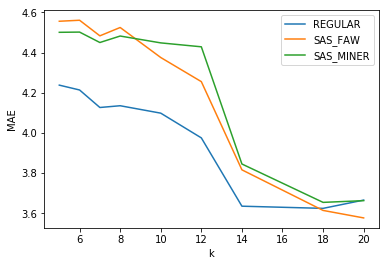

Text(0,0.5,'MSE')

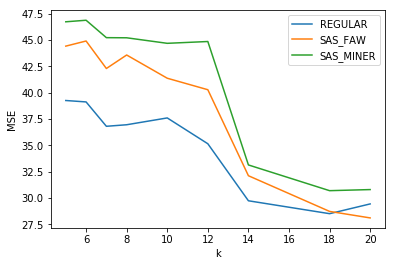

In [52]:
for i in range(3):
    plt.plot(k, mae[i])
plt.legend( ['REGULAR', 'SAS_FAW', 'SAS_MINER'] )
plt.xlabel('k')
plt.ylabel('MAE')
plt.show()
for i in range(3):
    plt.plot(k, mse[i])
plt.legend( ['REGULAR', 'SAS_FAW', 'SAS_MINER'] )
plt.xlabel('k')
plt.ylabel('MSE')

# Предсказание (результат записывается в файл predictions.csv)

In [ ]:
with open('rf_18.pickle', 'rb') as f:
    rf = pickle.load(f)
params = {'product_features': prod_feat, 'training_step': 7, 'k': 18, 'base_algs_num': 3}
forecast_ba_all, time_ser_all = data_prep(ts, base_algs, 1, params)
X, y = make_dataset(forecast_ba_all, time_ser_all, 1, params)
X = X.reshape(-1, X.shape[0] // ts.shape[0], X.shape[1])
y = y.T.reshape(-1, y.shape[1] // ts.shape[0], y.shape[0])
pred = []
for i in range(len(rf)):
    pred.append( rf[i].predict(X[:, -1, :]) )
pred = np.array( pred)
weights = softmax(-pred.T)

res = []
i = 0
for (pr_id, st_id), _ in ts.iterrows():
    reg = np.array(base_algs.loc[pr_id, st_id]['REGULAR'], dtype=np.float)
    faw = np.array(base_algs.loc[pr_id, st_id]['SAS_FAW'], dtype=np.float)
    miner = np.array(base_algs.loc[pr_id, st_id]['SAS_MINER'], dtype=np.float)
    
    r = weights[i, 0] * reg + weights[i, 1] * faw + weights[i, 2] * miner
    res.append([pr_id, st_id, *list(r) ])
    i += 1
dates = list(map(lambda x: datetime.fromordinal(x).date().isoformat(), base_algs['dt'][0] ))
pd.DataFrame(data=res, columns=['PRODUCT_ID', 'STORE_LOCATION_ID', *dates]).to_csv('predictions.csv')